<a href="https://colab.research.google.com/github/wooi-haw/flowers_classification/blob/main/cnn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of five types of flowers (from scratch)
## In this example, we are going to train a CNN model from scratch for the classfication of five types of flowers

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Extract dataset from Google Drive
!cd /content/
!unzip /content/drive/MyDrive/five_flowers.zip > /dev/null

In [3]:
# Load modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Setup training images and testing images
train_dir = 'five_flowers/train/'
test_dir = 'five_flowers/test/'
val_dir = 'five_flowers/valid/'

train_datagen = ImageDataGenerator(
                    rescale=1/255.,
                    rotation_range=30,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255.)

val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical',
                    shuffle=False)

val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical',
                    shuffle=False)

Found 3668 images belonging to 5 classes.
Found 306 images belonging to 5 classes.
Found 343 images belonging to 5 classes.


In [5]:
# Construct CNN
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

# Compile and train model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=115,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=11,
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [6]:
scores = model.evaluate(test_generator)
print(f"{model.metrics_names[0]}: {scores[0]:.2f}")
print(f"{model.metrics_names[1]}: {scores[1]:.2%}")

10/10 [==============================] - 1s 81ms/step - loss: 0.8851 - acc: 0.7026
loss: 0.89
acc: 70.26%


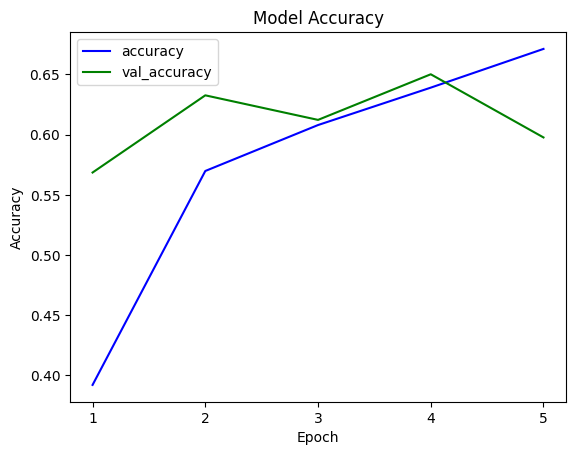

In [7]:
# Plot model accuracy and lose
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(np.arange(1, len(acc) + 1), acc, 'b', label='accuracy')
plt.plot(np.arange(1, len(val_acc) + 1), val_acc, 'g', label='val_accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, len(acc) + 1))
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)
plt.show()

10/10 [==============================] - 1s 88ms/step


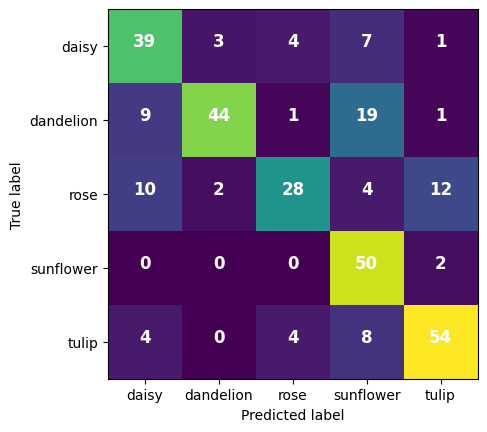

In [8]:
# Show the confusion matrix
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.style.use('default')
fig = plt.figure()
ax = plt.gca()
im = ax.matshow(cm)
for i, j in enumerate(cm.ravel()):
    ax.text(i%5, i//5, f'{j}', color='w', size='large', weight='bold', ha='center')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(5))
ax.set_xticklabels(list(train_generator.class_indices))
ax.set_yticks(np.arange(5))
ax.set_yticklabels(list(train_generator.class_indices))
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model1.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

from json import dump
with open('class_indices1.json', 'w') as f:
  dump(train_generator.class_indices, f)

Saved model to disk


In [10]:
# Test the trained model on a new image
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from json import load
import numpy as np

# load json and create model
json_file = open('model1.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("model1.h5")

# load class indices
with open('class_indices1.json', 'r') as f:
    class_indices = load(f)
print("Model loaded from disk")
map2class = {class_indices[k]:k for k in class_indices}

Model loaded from disk


1/1 [==============================] - 0s 27ms/step
[[0.00176632 0.00367741 0.00274342 0.86016697 0.1316458 ]]
daisy     :  0.002
dandelion :  0.004
rose      :  0.003
sunflower :  0.860
tulip     :  0.132


Text(0.5, 0, 'Predicted as sunflower')

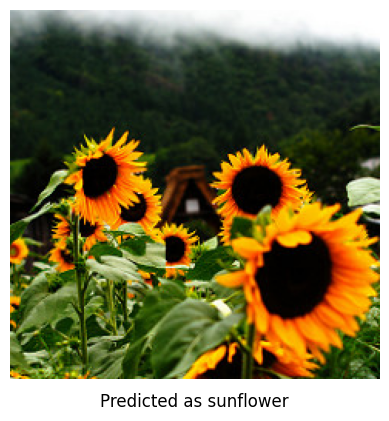

In [16]:
# Display the test image and show the predicted class
file = 'five_flowers/test/sunflower/sunflower_test_0001.jpg'
img = load_img(file, target_size=(150, 150))
x = img_to_array(img)/255.
x = np.expand_dims(x, axis=0)
classes = model.predict(x)
print(classes)
for i, k in enumerate(class_indices):
  print(f'{k:10}: {classes[0, i]: .3f}')

plt.axis(False)
plt.imshow(load_img(file))
plt.title(f'Predicted as {map2class[classes.argmax()]}', y=0, pad=-10, verticalalignment="top")